In [ ]:
!pip install tensorflow-io==0.17

In [ ]:
import os
import pathlib
import re
import shutil
import math
import librosa

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow import keras
from string import ascii_lowercase
import librosa.core as lc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

if os.path.exists('/content/drive/MyDrive/Training/training.zip'):
  with zipfile.ZipFile('/content/drive/MyDrive/Training/training.zip','r') as f:
    f.extractall('./')

### GetCleanFile Class


Use for librespeech *dataset*

In [ ]:
class GetCleanFile:
  def __init__(self, origin, new_path, newer_path, zip_file):
    self.origin = origin
    self.new_path = new_path
    self.newer_path = newer_path
    self.zip_file = zip_file
    self.train_path = ""
    
    # make new directory to contain organized sub-directory
    if not os.path.exists(self.newer_path):
      os.mkdir(self.newer_path)
  
  def __call__(self):
    # download data from the web server
    data_dir = pathlib.Path(self.new_path)
    
    if not data_dir.exists():
      tf.keras.utils.get_file(
          self.zip_file,
          origin = self.origin,
          extract = True,
          cache_dir = '.',
          cache_subdir = self.new_path.split('/')[-1])
      
    return self
  
  def get_path (self):
    '''get data directory path'''
    all_file = os.listdir(self.new_path)
    dir = [i for i in all_file if not re.match('[\w]*.zip',i)][0]
    path = os.path.join(self.new_path,dir)
    train_test_dir = [i for i in os.listdir(path) if not re.match('[\w]*.TXT',i)][0]
    self.train_path = os.path.join(path,train_test_dir)
    return self

  def get_subdirectory(self):
    '''including subdirectories and excluding upper directories'''
    return tf.io.gfile.glob(str(self.train_path)+'/*/*')

  def rename_and_move_dir(self, dir_names):
    ''' rename the sub-directory and move the subdirectory
        to another directory'''
    for i, dir in enumerate(dir_names):
        split_dir = dir.split('/')
        split_dir[-1] = str(i)
        joined_dir = '/'.join(split_dir)
        shutil.move(dir, joined_dir)
        shutil.move(joined_dir, self.newer_path)
    return self
  
  def delete_directory(self):
    '''delete initial data directory'''
    shutil.rmtree(self.new_path)

  def clean_label(self, subdirs):
    '''process the label so its content does not have filename in front of each
        lines'''
    for subdir in subdirs:
      # Define sub-directory for the new files
      new_subdir = subdir.split('/')[:-1]
      new_subdir = '/'.join(new_subdir)

      with open(subdir, 'r') as f:
      
        # Read all lines and return as list
        lines = f.readlines()

        # iterate line by line
        for line in lines:
          new_name = line.split()[0]
          content = ' '.join(line.split()[1:]).lower()
          file_subdir = os.path.join(new_subdir, f'{new_name}.txt')
          with open(file_subdir, 'w') as new_file:
            new_file.write(content)

        # delete initial text file
        os.remove(subdir)

Use for LJ speech dataset

In [ ]:
def load_LJdata(new_path, newer_path, data_dirname):
  """Load LJ speech dataset
      Please input data_dirname parameter with 'dirname'
      dirname and subdirname are arbitrary alphanumeric string"""
  if not os.path.exists(newer_path):
      os.mkdir(newer_path)

  data_dirname_status = bool(re.match(r'[\w\d]*', data_dirname))
  if data_dirname_status:
    data_dir = pathlib.Path(new_path)

    if not data_dir.exists():
      tf.keras.utils.get_file(
        os.path.join(os.getcwd(), "data.tar.gz"),
        "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2",
        extract=True,
        archive_format="tar",
        cache_dir="./",
      )

    audio_dirs = sorted(tf.io.gfile.glob(str(new_path)+'/*/*/*.wav'))
    new_data_path = os.path.join(newer_path, data_dirname)

    if not os.path.exists(new_data_path):
      os.mkdir(new_data_path)
      for audio_dir in audio_dirs:
        shutil.move(audio_dir, new_data_path)
    
    try:
      text_dir = tf.io.gfile.glob(str(new_path)+'/*/*.csv')[0]
      text_dir = pathlib.Path(text_dir)
    except IndexError:
      pass

    try:
      if text_dir.exists():
        with open((text_dir), encoding="utf-8") as f:
          for line in f:
            id = line.strip().split("|")[0]
            text = line.strip().split("|")[2]
            file_subdir = os.path.join(new_data_path, f'{id}.txt')
            with open(file_subdir, 'w') as new_file:
              new_file.write(text)
        os.remove(text_dir)
    except UnboundLocalError:
      pass

  else:
    raise Exception("data_dirname doesn't match with the requested format")


### FileSelection

In [ ]:
class FileFilter:
  def __init__(self, path):
    self.path = path
    self.max_length = 0
    self.done = True

  def filter_file(self):
    """ Filter file that has more than 10 seconds duration"""
    audio_dirs = tf.io.gfile.glob(str(self.path)+'/*/*.flac')
    for dir in audio_dirs:
      duration = librosa.get_duration(filename=dir)
      if duration > 10.0:
        text_path = dir.replace('flac', 'txt')
        os.remove(dir)
        os.remove(text_path)
    self.done = False
    return self

  def max_character(self):
    """ Return max character in text file"""
    text_dirs = tf.io.gfile.glob(str(self.path)+'/*/*.txt')
    lengths = []
    for dir in text_dirs:
      with open(dir, 'r') as f:
        line = f.readlines()[0]
        length = len(line)
        lengths.append(length)
    self.max_length = tf.math.maximum(lengths)
    return self.max_length


### EncodingDecoding Class

In [ ]:
class EncodingDecoding:
  def __init__(self):
    self.char = (["-", "#", "<", ">"]
                 + [c for c in ascii_lowercase]
                 + [" ", ".", ",", "?","'"])

  def encode_label(self, label):
    keys_tensor = tf.constant(self.char)
    vals_tensor = tf.constant(np.arange(len(self.char)))
    input_tensor = label

    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=30)
    
    return table.lookup(input_tensor)

  def decode_label(self,predicted_label):
    keys_tensor = tf.constant(np.arange(len(self.char)))
    vals_tensor = tf.constant(self.char)
    input_tensor = tf.cast(predicted_label, dtype=tf.int64)

    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value='')
    
    return table.lookup(input_tensor)
  
  @tf.function
  def decode_audio(self, audio_file):
    ''' decode flac file to float tensor'''
    audio = tfio.IOTensor.graph(tf.int16).from_audio(audio_file)
    audio_tensor = tf.squeeze(audio.to_tensor(), axis=-1)
    waveform = tf.cast(audio_tensor, tf.float32)/32768.0

    return waveform

### AudioDataProcessing Class

In [ ]:
class AudioDataProcessing:
  def __init__(self):
    self.pad_len = 2754

  def db_scale(self, S, amin=1e-16, top_db=80.0):
    """Convert spectrogram to decible units"""
    def _tf_log10(x):
        numerator = tf.math.log(x)
        denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
        return numerator / denominator
    
    ref = tf.reduce_max(S)

    log_spec = 10.0 * _tf_log10(tf.maximum(amin, S))
    log_spec -= 10.0 * _tf_log10(tf.maximum(amin, ref))

    log_spec = tf.maximum(log_spec, tf.reduce_max(log_spec) - top_db)

    return log_spec
    
  def get_spectrogram(self, waveform):
    '''Create spectogram from audio wave form'''
    #Extracting log spectrogram from audio waveform
    waveform = tf.cast(waveform, tf.float32)
    spectrogram = tf.signal.stft(
        waveform, 
        frame_length=200, 
        frame_step=80, 
        fft_length=256)
    log_spectrogram = tf.math.pow(tf.abs(spectrogram), 0.5)
    log_spectrogram = self.db_scale(log_spectrogram)

    # normalisation
    means = tf.math.reduce_mean(log_spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(log_spectrogram, 1, keepdims=True)
    x = (log_spectrogram - means) / stddevs
    
    #padding to 10 seconds
    pad_len = self.pad_len
    paddings = tf.constant([[0, self.pad_len], [0, 0]])
    x = tf.pad(x, paddings, "CONSTANT")[:self.pad_len, :]
    x = tf.where(tf.math.is_nan(x), tf.ones_like(x) * 0, x)
    return x

  def spec_augment(self):
    '''perform data augmentation for audio log spectrogram'''
    param = np.random.randint(1,100)
    augmentation = tf.keras.Sequential([
       layers.Lambda(lambda x : tfio.experimental.audio.freq_mask(x, param)),
       layers.Lambda(lambda x : tfio.experimental.audio.time_mask(x, param))            
    ])

### GetWaveformLabel Class

In [ ]:
class GetWaveformLabel(EncodingDecoding):
  def __init__(self):
    super().__init__()
    self.max_length = 200
    
  def get_waveform_label(self, audio_file, text_file):
    # decode WAV audio file
    waveform = super().decode_audio(audio_file)
    
    #convert tensor into str
    text = tf.io.read_file(text_file)

    #slice text so it will be under 198 character
    def string_slice(x):
      text_slice = x.numpy()[:self.max_length-2]
      return text_slice

    text_slice = tf.py_function(func=string_slice, inp=[text], Tout=tf.string)
    text_slice.set_shape(text.get_shape())

    #split char from whole string
    chars = tf.strings.join([b'<', text_slice, b'>'])
    chars = tf.strings.bytes_split(chars)
    

    # encode text file to numeric values  
    label = super().encode_label(chars)

    zero_padding = tf.zeros([self.max_length] - tf.shape(label), dtype=tf.int64)

    # Concatenate encode text with padding so that all encode text will be of the 
    # same length
    label = tf.concat([label, zero_padding], 0)
    label = tf.cast(label, dtype=tf.int32)

    return waveform, label

### GetProcessDataLabel

In [ ]:
class GetProcessDataLabel(AudioDataProcessing):
  def __init__(self):
    super().__init__()
  
  def get_process_label(self, waveform, label, train):
    x = super().get_spectrogram(waveform)
    if train:
      x = super().spec_augment()(x)
    return x, label

### Model

Model is modified version from Apoorv Nandan (https://github.com/keras-team/keras-io/blob/master/examples/audio/transformer_asr.py)

In [ ]:
class CharacterErrorRate(tf.keras.metrics.Metric):
  def __init__(self, name="character_error_rate", **kwargs):
    super().__init__(name=name, **kwargs)
    self.error_rate = self.add_weight(name='total_cer', initializer='zeros')
    self.counter = self.add_weight(name="cer_count", initializer="zeros")

  def update_state(self, y_true, y_pred, sample_weight=None):
    logit = tf.argmax(y_pred, axis=-1, output_type=tf.int32)
    cast_y = tf.cast(y_true, tf.int32)

    sparse_pred = tf.sparse.from_dense(logit)
    sparse_true = tf.sparse.from_dense(cast_y)

    sparse_pred = tf.sparse.retain(sparse_pred, 
                                   tf.not_equal(sparse_pred .values, -1))
    distance = tf.edit_distance(sparse_pred, sparse_true, normalize=True)

    self.error_rate.assign_add(tf.reduce_sum(distance))
    self.counter.assign_add(tf.cast(len(y_true), tf.float32))

  def result(self):
    return tf.math.divide_no_nan(self.error_rate, self.counter)

  def reset_states(self):
    # The state of the metric will be reset at the start of each epoch.
    self.error_rate.assign(0.0)
    self.counter.assign(0.0)


In [ ]:
class TokenEmbedding(layers.Layer):
  def __init__(self, num_vocab=1000, maxlen=100, num_hid=64):
    super().__init__()
    self.num_vocab = num_vocab
    self.maxlen = maxlen
    self.num_hid = num_hid

    self.emb = layers.Embedding(num_vocab, num_hid)
    self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=num_hid)

  def call(self, x):
    maxlen = tf.shape(x)[-1]
    x = self.emb(x)
    positions = tf.range(start=0, limit=maxlen, delta=1)
    positions = self.pos_emb(positions)
    return x + positions

  def get_config(self):
    config = super().get_config()
    config.update({"num_vocab": self.num_vocab,
                    "maxlen": self.maxlen,
                    "num_hid": self.num_hid})
    return config

  @classmethod
  def from_config(cls, config):
      return cls(**config)


class SpeechFeatureEmbedding(layers.Layer):
  def __init__(self, num_hid=64, maxlen=100):
    super().__init__()
    self.num_hid = num_hid
    self.maxlen = maxlen

    self.conv1 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
    self.conv2 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
    self.conv3 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
    self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=num_hid)
    
  def call(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    return self.conv3(x)

  def get_config(self):
    config = super().get_config()
    config.update({"num_hid": self.num_hid,
                    "maxlen": self.maxlen})
    return config

  @classmethod
  def from_config(cls, config):
    return cls(**config)

In [ ]:
class TransformerEncoder(layers.Layer):
  def __init__(self, embed_dim, num_heads, feed_forward_dim, rate=0.1):
    super().__init__()
    self.embed_dim = embed_dim
    self.num_heads = num_heads
    self.feed_forward_dim = feed_forward_dim
    self.rate = rate

    self.att = layers.MultiHeadAttention(num_heads=num_heads, 
                                             key_dim=embed_dim)
    self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
    self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
    self.dropout1 = layers.Dropout(rate)
    self.dropout2 = layers.Dropout(rate)

  def call(self, inputs, training):
    attn_output = self.att(inputs, inputs)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(inputs + attn_output)
    ffn_output = self.ffn(out1)
    ffn_output = self.dropout2(ffn_output, training=training)
    return self.layernorm2(out1 + ffn_output)

  def get_config(self):
    config = super().get_config()
    config.update({"embed_dim": self.embed_dim,
                    "num_heads": self.num_heads,
                    "feed_forward_dim": self.feed_forward_dim,
                     "rate": self.rate})
    return config

  @classmethod
  def from_config(cls, config):
    return cls(**config)

In [ ]:
class TransformerDecoder(layers.Layer):
  def __init__(self, embed_dim, num_heads, feed_forward_dim, **kwargs):
    super().__init__(**kwargs)
    self.embed_dim = embed_dim
    self.num_heads = num_heads
    self.feed_forward_dim = feed_forward_dim

    self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)
    self.self_att = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
    self.enc_att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.self_dropout = layers.Dropout(0.5)
    self.enc_dropout = layers.Dropout(0.1)
    self.ffn_dropout = layers.Dropout(0.1)
    self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
    
 
  def causal_attention_mask(self, batch_size, n_dest, n_src, dtype):
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)

  def call(self, enc_out, target):
    input_shape = tf.shape(target)
    batch_size = input_shape[0]
    seq_len = input_shape[1]
    causal_mask = self.causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
    target_att = self.self_att(target, target, attention_mask=causal_mask)
    target_norm = self.layernorm1(target + self.self_dropout(target_att))
    enc_out = self.enc_att(target_norm, enc_out)
    enc_out_norm = self.layernorm2(self.enc_dropout(enc_out) + target_norm)
    ffn_out = self.ffn(enc_out_norm)
    ffn_out_norm = self.layernorm3(enc_out_norm + self.ffn_dropout(ffn_out))
    return ffn_out_norm

  def get_config(self):
    config = super().get_config()
    config.update({"embed_dim": self.embed_dim,
                    "num_heads": self.num_heads,
                    "feed_forward_dim": self.feed_forward_dim})
    return config

  @classmethod
  def from_config(cls, config):
    return cls(**config)


In [ ]:
class Transformer(keras.Model):
  def __init__(
      self,
      num_hid=64,
      num_head=2,
      num_feed_forward=128,
      source_maxlen=100,
      target_maxlen=100,
      num_layers_enc=4,
      num_layers_dec=1,
      num_classes=10,
    ):
      super().__init__()
      self.num_hid = num_hid
      self.num_head = num_head
      self.num_feed_forward = num_feed_forward
      self.source_maxlen = source_maxlen
      self.target_maxlen = target_maxlen
      self.num_layers_enc = num_layers_enc
      self.num_layers_dec = num_layers_dec
      self.target_maxlen = target_maxlen
      self.num_classes = num_classes

      self.loss_metric = keras.metrics.Mean(name="loss")
      self.cer = CharacterErrorRate()

      self.enc_input = SpeechFeatureEmbedding(num_hid=num_hid, maxlen=source_maxlen)
      self.dec_input = TokenEmbedding(
          num_vocab=num_classes, maxlen=target_maxlen, num_hid=num_hid
      )

      self.encoder = keras.Sequential(
            [self.enc_input]
            + [
                TransformerEncoder(num_hid, num_head, num_feed_forward)
                for _ in range(num_layers_enc)
            ]
        )

      for i in range(num_layers_dec):
        setattr(
            self,
            f"dec_layer_{i}",
            TransformerDecoder(num_hid, num_head, num_feed_forward),
        )

      self.classifier = layers.Dense(num_classes)

      serialized_token_emb = keras.layers.serialize(self.dec_input)
      serialized_speech_emb = keras.layers.serialize(self.enc_input)
      serialized_trafo_decoder = keras.layers.serialize(TransformerEncoder(num_hid, 
                                                                           num_head, 
                                                                           num_feed_forward))
      serialized_trafo_encoder = keras.layers.serialize(TransformerDecoder(num_hid, 
                                                                           num_head, 
                                                                           num_feed_forward))

  def decode(self, enc_out, target):
    y = self.dec_input(target)
    for i in range(self.num_layers_dec):
      y = getattr(self, f"dec_layer_{i}")(enc_out, y)
    return y

  def call(self, inputs):
    source = inputs[0]
    target = inputs[1]
    x = self.encoder(source)
    y = self.decode(x, target)
    return self.classifier(y)

  @property
  def metrics(self):
    return [self.loss_metric, self.cer]
 
  def train_step(self, batch):
    """Processes one batch inside model.fit()."""
    batch = dict(source = batch[0], target = batch[1])
    source = batch["source"]
    target = batch["target"]
    dec_input = target[:, :-1]
    dec_target = target[:, 1:]
    with tf.GradientTape() as tape:
      preds = self([source, dec_input])
      one_hot = tf.one_hot(dec_target, depth=self.num_classes)
      mask = tf.math.logical_not(tf.math.equal(dec_target, 0))
      loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
    trainable_vars = self.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    self.optimizer.apply_gradients(zip(gradients, trainable_vars))
    self.cer.update_state(dec_target, preds)
    self.loss_metric.update_state(loss)
    return {"loss": self.loss_metric.result(), 
      "cer": tf.math.subtract(self.cer.result(), tf.constant(1.0, tf.float32))}
 
  def test_step(self, batch):
    batch = dict(source = batch[0], target = batch[1])
    source = batch["source"]
    target = batch["target"]
    dec_input = target[:, :-1]
    dec_target = target[:, 1:]
    preds = self([source, dec_input])
    one_hot = tf.one_hot(dec_target, depth=self.num_classes)
    mask = tf.math.logical_not(tf.math.equal(dec_target, 0))
    loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
    self.loss_metric.update_state(loss)
    return {"loss": self.loss_metric.result()}

  def generate(self, source):
    """Performs inference over one batch of inputs using greedy decoding."""
    bs = tf.shape(source)[0]
    enc = self.encoder(source)
    dec_input = tf.ones((bs, 1), dtype=tf.int32) * tf.constant(2)
    for i in range(self.target_maxlen - 1):
      dec_out = self.decode(enc, dec_input)
      logits = self.classifier(dec_out)
      logits = tf.argmax(logits, axis=-1, output_type=tf.int32)
      last_logit = tf.expand_dims(logits[:, -1], axis=-1)
      dec_input = tf.concat([dec_input, last_logit], axis=-1)
    return dec_input

  def get_config(self):
    config = super().get_config()
    config_content={}
    config_content.update(serialized_token_emb)
    config_content.update(serialized_speech_emb)
    config_content.update(serialized_trafo_decoder)
    config_content.update(serialized_trafo_encoder)
    config.update(config_content)
    return config 

  @classmethod
  def from_config(cls, config):
    return cls(**config)

### Extract

In [ ]:
class TrainTestDataset:
  def organize_file(self, origin, new_path, newer_path, zip_file):
    get_clean_file = GetCleanFile(origin,new_path,newer_path, zip_file)
    dir_names = get_clean_file().get_path().get_subdirectory()
    get_clean_file.rename_and_move_dir(dir_names)
    get_clean_file.delete_directory()

    subdir = tf.io.gfile.glob(newer_path + '/*/*.txt')
    subdir_1 = tf.io.gfile.glob(newer_path + '/*/*.flac')
    get_clean_file.clean_label(subdir)
    return self

  def prepare_dataset(self, path):
    audio_file= sorted(tf.io.gfile.glob(str(newer_path) + '/*/*.flac'))
    audio_file_wav = sorted(tf.io.gfile.glob(str(newer_path) + '/*/*.wav'))
    audio_file.extend(audio_file_wav)
    audio_file = np.array(audio_file)
    text_file = sorted(np.array(tf.io.gfile.glob(str(newer_path) + '/*/*.txt')))
    list_ds = tf.data.Dataset.from_tensor_slices((audio_file, text_file))
    return list_ds

  def preprocess_dataset(self, list_ds, train):
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    get_waveform_label = GetWaveformLabel()
    get_process_data_label = GetProcessDataLabel()
  
    waveform_ds = list_ds.map(get_waveform_label.get_waveform_label, 
                            num_parallel_calls=AUTOTUNE)
    waveform_ds = waveform_ds.prefetch(AUTOTUNE)

    spectrogram_ds = waveform_ds.map(
        lambda x,y : get_process_data_label.get_process_label(x, y, train), 
        num_parallel_calls=AUTOTUNE)

    return spectrogram_ds


In [ ]:
origin = 'https://www.openslr.org/resources/12/train-clean-100.tar.gz'
new_path = './data'
newer_path = './DATA'

val_origin = 'https://www.openslr.org/resources/12/test-clean.tar.gz'
val_new_path = './val_data'
val_newer_path = './VAL_DATA'

lj_path = './datasets'
data_dirname = 'LJdata'

create_train_ds = TrainTestDataset()
create_test_ds = TrainTestDataset()
filter_train_ds = FileFilter(newer_path)
filter_test_ds = FileFilter(val_newer_path)

if not os.path.exists(newer_path):
  create_train_ds.organize_file(origin, new_path, newer_path, 'train.zip')
filter_train_ds.filter_file() if filter_train_ds.done else print('filter has been done')
load_LJdata(lj_path, newer_path, data_dirname)
list_ds = create_train_ds.prepare_dataset(newer_path)
train_ds = create_train_ds.preprocess_dataset(list_ds, train=False)

if not os.path.exists(val_newer_path):
  create_test_ds.organize_file(val_origin, val_new_path, val_newer_path, 'test.zip')
filter_test_ds.filter_file() if filter_test_ds.done else print('filter has been done')
val_list_ds = create_test_ds.prepare_dataset(val_newer_path)
val_ds = create_test_ds.preprocess_dataset(val_list_ds, train=False)

train_ds = train_ds.shuffle(1024).batch(64)
val_ds = val_ds.batch(32)

2748579840/2748572632 [==============================] - 40s 0us/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Creating resources inside a function passed to Dataset.map() is not supported. Create each resource outside the function, and capture it inside the function to use it.


346669056/346663984 [==============================] - 11s 0us/step


In [ ]:
batch = next(iter(train_ds))

Text(0.5, 1.0, 'Spectrogram')

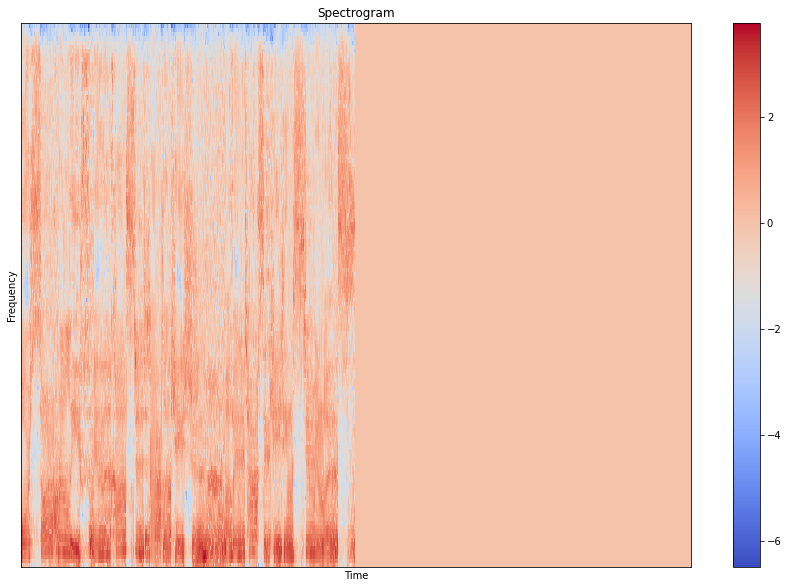

In [ ]:
import librosa.display
FIG_SIZE = (15,10)

plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(batch[0][50].numpy().T, sr=22050, hop_length=80)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.title("Spectrogram")

### Training

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
class SaveCheckpoint(tf.keras.callbacks.Callback):
  def __init__(self, ckpt_path, model, optimizer):
    super().__init__()
    self.ckpt_path = ckpt_path
    self.model = model
    self.optimizer = optimizer

  def on_epoch_end(self, epoch, logs={}):
    ckpt = tf.train.Checkpoint(model=self.model,
                           optimizer=self.optimizer)

    ckpt_manager = tf.train.CheckpointManager(ckpt, self.ckpt_path, max_to_keep=5)
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {self.ckpt_path}')

In [ ]:
def create_model(optimizer):
  model = Transformer(
      num_hid=256,
      num_head=4,
      num_feed_forward=1024,
      target_maxlen=200,
      num_layers_enc=4,
      num_layers_dec=1,
      num_classes=35,
    )
  loss_fn = tf.keras.losses.CategoricalCrossentropy(
      from_logits=True, label_smoothing=0.1,
    )
  model.compile(optimizer=optimizer, loss=loss_fn, metrics=[CharacterErrorRate()])
  
  return model

Run cell dibawah buat train model

In [ ]:
checkpoint_path = "./training/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
learning_rate = CustomSchedule(d_model=256)
optimizer = keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)
model = create_model(optimizer)
path = './checkpoint/train'
ckpt_callback = SaveCheckpoint(path, model, optimizer)

epochs = 10

history = model.fit(train_ds, validation_data=val_ds,
                    epochs=epochs,
                    callbacks = [cp_callback, ckpt_callback])

Kalau model belum selesai ditrain, save dulu file checkpointnya terus run kode dibawah

In [ ]:
learning_rate = CustomSchedule(d_model=256)
optimizer = keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)
model = create_model(optimizer)

# Load the previously saved weights
model.load_weights('./training/cp.ckpt')

epochs=1

history = model.fit(train_ds, steps_per_epoch=50,
                    epochs=epochs, verbose=1)

50/50 [==============================] - 180s 2s/step - loss: 0.4735 - cer: 0.3267


### Test Model

In [ ]:
def inference(model, spectrogram):
  dec_input = tf.constant(2, tf.int32)[tf.newaxis]
  label = model.generate(spectrogram)
  label = tf.squeeze(label, axis=0)

  for i in label[1:]:
    if tf.math.logical_not(tf.math.equal(i, 3)):
      i = tf.expand_dims(i, axis=0)
      dec_input = tf.concat([dec_input, i], axis=0)
    else:
      break

  decoding = EncodingDecoding()
  label = decoding.decode_label(tf.cast(dec_input,dtype=tf.int64))
  
  label = b''.join(label.numpy()).decode('utf-8')
  return label

In [ ]:
decoding = EncodingDecoding()
audio_processing = AudioDataProcessing()

# Convert audio file to db-scale spectrogram
waveform = decoding.decode_audio('/content/DATA/LJdata/LJ001-0004.wav')
spectrogram = audio_processing.get_spectrogram(waveform)
x = tf.expand_dims(spectrogram, axis=0)

In [ ]:
inference(model, x)

'<produced the blooks, which were the immediate predecessors of the true printed book,'

### Saved weight

In [ ]:
model.save_weights('./weights/my_weights', save_format='tf')

In [ ]:
!tar -zcvf weights.tar.gz /content/weights

In [ ]:
!mv /content/weights.tar.gz /content/drive/MyDrive/Weight